# ZDT1

## Imports

In [21]:
import os

import matplotlib.pyplot as plt
import pandas as pd

import bofire.strategies.api as strategies
from bofire.benchmarks.api import ZDT1
from bofire.data_models.domain.api import Domain
from bofire.data_models.strategies.api import MoboStrategy, RandomStrategy
from bofire.data_models.surrogates.api import (
    BotorchSurrogates,
    SaasSingleTaskGPSurrogate,
    SingleTaskGPSurrogate,
)
from bofire.runners.api import run
from bofire.utils.multiobjective import compute_hypervolume, get_pareto_front
from bofire.data_models.priors.api import BOTORCH_LENGTHCALE_PRIOR, MBO_LENGTHCALE_PRIOR, DimensionalityScaledLogNormalPrior, LogNormalPrior, BOTORCH_NOISE_PRIOR, MBO_NOISE_PRIOR, MBO_OUTPUTSCALE_PRIOR, BOTORCH_SCALE_PRIOR, HVARFNER_LENGTHSCALE_PRIOR, HVARFNER_NOISE_PRIOR, NormalPrior, GammaPrior
from bofire.plot.api import plot_prior_pdf_plotly
from bofire.data_models.kernels.api import ScaleKernel, MaternKernel, RBFKernel
import bofire.priors.api as priors

SMOKE_TEST = os.environ.get("SMOKE_TEST")

N_ITERATIONS = 50 if not SMOKE_TEST else 1
BATCH_SIZE = 5 if not SMOKE_TEST else 1
WARMUP_STEPS = 256 if not SMOKE_TEST else 32
NUM_SAMPLES = 128 if not SMOKE_TEST else 16
THINNING = 16

## Random Optimization

In [23]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

def hypervolume(domain: Domain, experiments: pd.DataFrame) -> float:
    return compute_hypervolume(
        domain, experiments, ref_point={"y1": 1.0, "y2": 5.}
    )

random_results = run(
    ZDT1(n_inputs=30),
    strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
    n_iterations=N_ITERATIONS,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 1.555: 100%|██████████| 50/50 [00:01<00:00, 36.85it/s]


## Optimization with Hvarfner priors

In [24]:
def strategy_factory(domain: Domain):
    data_model = MoboStrategy(domain=domain,  ref_point={"y1": 1., "y2": 5.})
    return strategies.map(data_model)

benchmark = ZDT1(n_inputs=30)


def strategy_factory(domain: Domain):
    data_model = MoboStrategy(
        domain=domain,
        ref_point={"y1": 1., "y2": 5.},
        surrogate_specs=BotorchSurrogates(
            surrogates=[
                SingleTaskGPSurrogate(inputs=benchmark.domain.inputs, outputs=benchmark.domain.outputs.get_by_keys(["y1"]),
                                          # the following hyperparams do not need to be provided
                                          kernel=RBFKernel(ard=True, lengthscale_prior=DimensionalityScaledLogNormalPrior()),
                                          noise_prior=HVARFNER_NOISE_PRIOR()),
                SingleTaskGPSurrogate(inputs=benchmark.domain.inputs, outputs=benchmark.domain.outputs.get_by_keys(["y2"]),
                                          # the following hyperparams do not need to be provided
                                          kernel=RBFKernel(ard=True, lengthscale_prior=DimensionalityScaledLogNormalPrior()),
                                          noise_prior=HVARFNER_NOISE_PRIOR()),
                                          ]))
    return strategies.map(data_model)

results = run(
    ZDT1(n_inputs=30),
    strategy_factory=strategy_factory,
    n_iterations=N_ITERATIONS,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 4.378: 100%|██████████| 50/50 [06:07<00:00,  7.34s/it]


## Optimization with default priors

In [26]:
def strategy_factory(domain: Domain):
    data_model = MoboStrategy(domain=domain,  ref_point={"y1": 1., "y2": 5.})
    return strategies.map(data_model)

benchmark = ZDT1(n_inputs=30)


def strategy_factory(domain: Domain):
    data_model = MoboStrategy(
        domain=domain,
        ref_point={"y1": 1., "y2": 5.},
        )
    return strategies.map(data_model)

results = run(
    ZDT1(n_inputs=30),
    strategy_factory=strategy_factory,
    n_iterations=N_ITERATIONS,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 2.331: 100%|██████████| 50/50 [09:56<00:00, 11.92s/it]


## SAASBO Optimization

In [6]:
def strategy_factory(domain: Domain):
    data_model = MoboStrategy(domain=domain,  ref_point={"y1": 1., "y2": 5.})
    return strategies.map(data_model)

benchmark = ZDT1(n_inputs=30)


def strategy_factory(domain: Domain):
    data_model = MoboStrategy(
        domain=domain,
        ref_point={"y1": 1., "y2": 5.},
        surrogate_specs=BotorchSurrogates(
            surrogates=[
                SaasSingleTaskGPSurrogate(inputs=benchmark.domain.inputs, outputs=benchmark.domain.outputs.get_by_keys(["y1"]),
                                          # the following hyperparams do not need to be provided
                                          warmup_steps=WARMUP_STEPS,
                                          num_samples=NUM_SAMPLES,
                                          thinning=THINNING),
                SaasSingleTaskGPSurrogate(inputs=benchmark.domain.inputs, outputs=benchmark.domain.outputs.get_by_keys(["y2"]),
                                          # the following hyperparams do not need to be provided
                                          warmup_steps=WARMUP_STEPS,
                                          num_samples=NUM_SAMPLES,
                                          thinning=THINNING)
                                          ]))
    return strategies.map(data_model)

results = run(
    ZDT1(n_inputs=30),
    strategy_factory=strategy_factory,
    n_iterations=N_ITERATIONS,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 4.578: 100%|██████████| 50/50 [1:32:20<00:00, 110.81s/it]


Plot the pareto front.

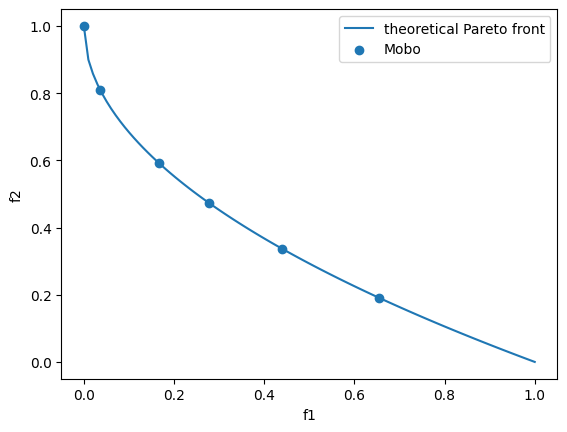

In [13]:
theoretical_front = benchmark.get_optima()
front = get_pareto_front(domain=benchmark.domain, experiments=results[0][0])

fig, ax = plt.subplots()
ax.plot(theoretical_front.y1, theoretical_front.y2, label="theoretical Pareto front")

ax.scatter(front.y1, front.y2, label="Mobo")
ax.set_xlabel("f1")
ax.set_ylabel("f2")


ax.legend()

plt.show()

Show the performance of the optimizer.

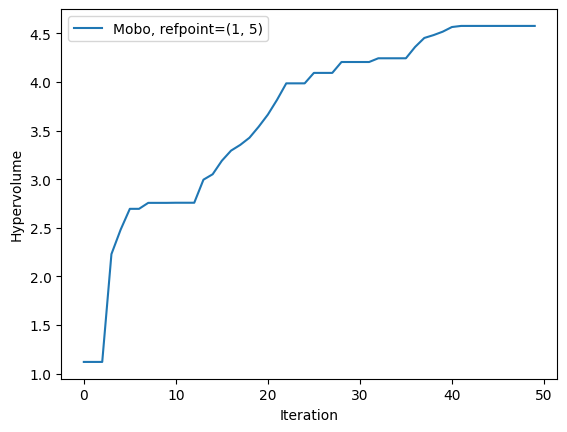

In [14]:
fig, ax = plt.subplots()

ax.plot(results[0][1], label="Mobo, refpoint=(1, 5)")

ax.set_ylabel("Hypervolume")
ax.set_xlabel("Iteration")

ax.legend()

In [16]:
# Priors

In [10]:
from bofire.data_models.priors.api import BOTORCH_LENGTHCALE_PRIOR, MBO_LENGTHCALE_PRIOR, DimensionalityScaledLogNormalPrior, LogNormalPrior, BOTORCH_NOISE_PRIOR, MBO_NOISE_PRIOR
from bofire.plot.api import plot_prior_pdf_plotly

mbo= MBO_LENGTHCALE_PRIOR()
botorch = BOTORCH_LENGTHCALE_PRIOR()
dimensionality = DimensionalityScaledLogNormalPrior(d=6)

plot_prior_pdf_plotly([mbo, botorch, dimensionality], 0.0001, 30, labels=["mbo", "botorch", "dimensionality"])


In [8]:
mbo= MBO_LENGTHCALE_PRIOR()
botorch = BOTORCH_LENGTHCALE_PRIOR()
dimensionality = DimensionalityScaledLogNormalPrior(d=6)
#ps = [DimensionalityScaledLogNormalPrior(d=i) for i in [5, 10, 20, 30]]
#labels = [str(i) for i in [5, 10, 20, 30]]

ds = [6, 10, 20, 30]

ps = [DimensionalityScaledLogNormalPrior(d=i, loc=2) for i in ds]
ps.append(mbo)
ps.append(botorch)
labels = [str(i) for i in ds]
labels.append("mbo")
labels.append("botorch")

plot_prior_pdf_plotly(ps, 0.0001, 10, labels=labels)

In [11]:
mbo= MBO_OUTPUTSCALE_PRIOR()
botorch = BOTORCH_SCALE_PRIOR()

plot_prior_pdf_plotly([mbo, botorch], 0.0001, 10, labels=["mbo", "botorch"])

In [4]:
mbo= MBO_NOISE_PRIOR()
botorch = BOTORCH_NOISE_PRIOR()
hvarfner = HVARFNER_NOISE_PRIOR()

plot_prior_pdf_plotly([mbo, botorch, hvarfner], 0.0001, 1, labels=["mbo", "botorch", "hvarfner"])

In [12]:
plot_prior_pdf_plotly([LogNormalPrior(loc=-4,scale=1), BOTORCH_NOISE_PRIOR(), MBO_NOISE_PRIOR()], 0.0001, 0.2)

In [13]:
BOTORCH_NOISE_PRIOR()

GammaPrior(type='GammaPrior', concentration=1.1, rate=0.05)

In [ ]:
data_model = DimensionalityScaledLogNormalPrior(d=6)

loc=data_model.loc + math.log(data_model.d) * data_model.loc_scaling
scale=(data_model.scale**2 + math.log(data_model.d) * data_model.scale_scaling),

In [22]:
import math

math.log(6)/2 + math.sqrt(2)

2.3100932969871226

In [25]:
math.sqrt(3)

1.7320508075688772

In [15]:
import math

math.sqrt(2)

1.4142135623730951

In [32]:
plot_prior_pdf_plotly(DimensionalityScaledLogNormalPrior(d=6), 0.0001, 30)

In [4]:
import plotly.express as px

df = px.data.gapminder().query("continent=='Oceania'")
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
60,Australia,Oceania,1952,69.120,8691212,10039.59564,AUS,36
61,Australia,Oceania,1957,70.330,9712569,10949.64959,AUS,36
62,Australia,Oceania,1962,70.930,10794968,12217.22686,AUS,36
63,Australia,Oceania,1967,71.100,11872264,14526.12465,AUS,36
64,Australia,Oceania,1972,71.930,13177000,16788.62948,AUS,36
65,Australia,Oceania,1977,73.490,14074100,18334.19751,AUS,36
66,Australia,Oceania,1982,74.740,15184200,19477.00928,AUS,36
67,Australia,Oceania,1987,76.320,16257249,21888.88903,AUS,36
68,Australia,Oceania,1992,77.560,17481977,23424.76683,AUS,36
69,Australia,Oceania,1997,78.830,18565243,26997.93657,AUS,36
